In [3]:
import utils
import pandas as pd
import numpy as np
from nltk import ngrams

In [4]:
qa_df = pd.read_json('../data/ms_macro_qa/dev_v2.1.json')

In [6]:
qa_df = qa_df.loc[:, ['answers', 'query']]

In [7]:
utils.save(qa_df, 'qa_df')

In [4]:
qa_df.shape

(101093, 6)

In [ ]:
qa_df.answers.value_counts() ## what to do with the '[No Answer Present.]'

In [5]:
qa_df.head()

,answers,passages,query,query_id,query_type,wellFormedAnswers
0,[A corporation is a company or group of people...,"[{'is_selected': 0, 'passage_text': 'A company...",. what is a corporation?,1102432,DESCRIPTION,[]
1,[Rachel Carson writes The Obligation to Endure...,"[{'is_selected': 0, 'passage_text': 'Read to w...",why did rachel carson write an obligation to e...,1102431,DESCRIPTION,[]
10,[No Answer Present.],"[{'is_selected': 0, 'passage_text': 'The Progr...",why did the progressive movement fail to advan...,1102421,DESCRIPTION,[]
100,[No Answer Present.],"[{'is_selected': 0, 'passage_text': 'On an ave...",why do police need to understand what the fore...,1102315,DESCRIPTION,[]
1000,[No Answer Present.],"[{'is_selected': 0, 'passage_text': 'A: Very, ...",do owls eat in the day,1101280,NUMERIC,[]


In [6]:
qa_df.sample(100)

,answers,passages,query,query_id,query_type,wellFormedAnswers
62835,"[Yes, Chamberlain College of Nursing is an HLC...","[{'is_selected': 0, 'passage_text': 'You also ...",is chamberlain college of nursing accredited,405918,DESCRIPTION,[]
71943,"[Angola, mining company Lucapa.]","[{'is_selected': 0, 'passage_text': 'The 1,111...",where was the large diamond just found,1003844,LOCATION,[]
2410,[he recovery of fingerprints from a crime scen...,"[{'is_selected': 0, 'passage_text': 'The three...",how are fingerprints discovered at crime scenes?,1099709,DESCRIPTION,[]
99019,[No Answer Present.],"[{'is_selected': 0, 'passage_text': 'Get maxim...",ferris is 1500z zero turn mower,186437,DESCRIPTION,[]
8465,[No Answer Present.],"[{'is_selected': 0, 'passage_text': 'Group Pol...",nosmhelp what is it,1092157,DESCRIPTION,[]
53678,[No Answer Present.],"[{'is_selected': 0, 'passage_text': 'The leave...",can you get bear grass in florists?,77715,DESCRIPTION,[]
47442,[No],"[{'is_selected': 1, 'passage_text': 'A Waiter/...",is waiter gender specific,431098,DESCRIPTION,[]
3417,[The bankruptcy record from the court is delet...,"[{'is_selected': 0, 'passage_text': 'I was suc...",how long does a bankruptcy show on public reco...,1098423,NUMERIC,[]
88321,[No Answer Present.],"[{'is_selected': 0, 'passage_text': 'NOTE: Eve...",which statement explains why conclusions from ...,1020051,DESCRIPTION,[]
3602,[No Answer Present.],"[{'is_selected': 0, 'passage_text': 'This step...",how long does it take to get dna results for i...,1098175,NUMERIC,[]


## Transform the questions into half of the feature space

In [7]:
questions = qa_df.loc[:, 'query']

In [8]:
questions[:10]

0                                  . what is a corporation?
1         why did rachel carson write an obligation to e...
10        why did the progressive movement fail to advan...
100       why do police need to understand what the fore...
1000                                 do owls eat in the day
10000                             symptoms of a dying mouse
100000          average number of lightning strikes per day
100001               can you burn your lawn with fertilizer
100002              are volvox autotrophic or heterotrophic
100003                          average force of a raindrop
Name: query, dtype: object

In [1]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer


In [2]:
## text transformation pipes
# clean_text = Pipeline(
#     [
#         ('stack', FunctionTransformer(utils.stack_questions, validate=False)),

#     ]
# )

# lemma_text = Pipeline(
#     [
#         ('lemma', FunctionTransformer(utils.apply_lemma, validate=False))
#     ]
# )

# # feature engineering pipes
# single_question_pipe = Pipeline(
#     [
#         ('dist', FunctionTransformer(utils.add_min_max_avg_distance_features, validate=False)),
# #         ('unstack', FunctionTransformer(utils.unstack_questions, validate=False))
#     ]
# )

# No Pairs
# pair_question_pipe = Pipeline(
#     [
#         ('ngram_sim', FunctionTransformer(utils.calc_ngram_similarity, kw_args={'n_grams':[1, 2, 3]}, validate=False))
#     ]
# )

# build features on the cleaned text only
clean_text_features = Pipeline(
    [
        ('clean', FunctionTransformer(utils.clean_questions, validate=False)),
        ('dist', FunctionTransformer(utils.add_min_max_avg_distance_features, validate=False))
    ]
)

# build features on the cleanned and lemmatized text features
lemma_text_features = Pipeline(
    [
        ('clean', FunctionTransformer(utils.clean_questions, validate=False)),
        ('lemma', FunctionTransformer(utils.apply_lemma, validate=False)),
        ('dist', FunctionTransformer(utils.add_min_max_avg_distance_features, validate=False))
    ]
)

# pre-process pipe
feature_transformation = Pipeline(
    [
        ('feats', FeatureUnion(
            [
                ('clean_text_features', clean_text_features),
                ('lemma_text_features', lemma_text_features)
            ]
        ))
    ]
)


NameError: name 'utils' is not defined

In [140]:
%%time
q_trans_clean = clean_text_features.transform(questions)

CPU times: user 2min 59s, sys: 16 s, total: 3min 15s
Wall time: 4min 4s


In [141]:
q_trans_clean.shape

(101093, 9)

In [142]:
%%time
q_trans_lemma = lemma_text_features.transform(questions)

CPU times: user 3min 39s, sys: 36.9 s, total: 4min 16s
Wall time: 5min 4s


In [143]:
q_trans_lemma.shape

(101093, 9)

In [144]:
utils.save(q_trans_clean, 'transformed_questions_clean')
utils.save(q_trans_lemma, 'transformed_questions_lemma')

In [82]:
df_cleaned_questions = pd.DataFrame(cleaned_questions)
df_cleaned_questions = df_cleaned_questions.rename(columns={0:'question1'})
df_cleaned_questions['id'] = df_cleaned_questions.index
df_cleaned_questions.head()

,question1,id
0,what is a corporation,0
1,why did rachel carson write an obligation to e...,1
2,why did the progressive movement fail to advan...,2
3,why do police need to understand what the fore...,3
4,do owls eat in the day,4


In [190]:
feature_pipe = utils.load('feature_pipe')

## App data

All data below needs to be pre-calculated

In [29]:
%%time
cleaned_questions = utils.clean_questions(questions)
lemma_questions = utils.apply_lemma(cleaned_questions)

utils.save(cleaned_questions, 'app_data/cleaned_questions')
utils.save(lemma_questions, 'app_data/lemma_questions')

CPU times: user 1min 1s, sys: 13.9 s, total: 1min 15s
Wall time: 1min 6s


In [30]:
def tokenize_questions(X):
    texts = []
    for doc in utils.nlp.pipe(X, disable=['parser', 'ner'], batch_size=10000):
        texts.append(doc.to_array([utils.spacy.attrs.LOWER]))
    return texts

In [31]:
%%time
clean_tokens = tokenize_questions(cleaned_questions)
lemma_tokens = tokenize_questions(lemma_questions)

utils.save(clean_tokens, 'app_data/clean_tokens')
utils.save(lemma_tokens, 'app_data/lemma_tokens')

CPU times: user 1min 48s, sys: 21 s, total: 2min 9s
Wall time: 1min 52s


In [52]:
%%time
clean_question_features = clean_text_features.transform(questions)
lemma_question_features = lemma_text_features.transform(questions)

utils.save(clean_question_features, 'app_data/clean_question_features')
utils.save(lemma_question_features, 'app_data/lemma_question_features')

CPU times: user 4min 4s, sys: 29.8 s, total: 4min 33s
Wall time: 3min 44s


In [68]:
xgb = utils.load('xgb_FINAL_model')

In [45]:
def ngram_similarity(q_token, token_db,  n_grams=[1, 2, 3]):
    ''' Calculates the ngram similarity between a pair of questions. Similarity is defined as,
            2 · ( |S1| / |S1 ∩ S2| + |S2| / |S1 ∩ S2|)^−1
        where S_i is the ngrams for question i
        
        n_grams: list
        List of n-grams to calculate, i.e. [1, 2, 3]
        
        return: array-like (n_pairs, len(n_grams))
        N-dimensional array of n_gram similarity calculated for the different n_grams.
        
    '''
    ngram_sim = []
    ngram_q2 = [set(ngrams(q_token, i, pad_right=True)) for i in n_grams]
    for t in token_db:
        ngram_q1 = [set(ngrams(t, i, pad_right=True)) for i in n_grams]

        doc_ngram_sim = []
        for i in range(len(ngram_q1)):
            try:
                s1 = len(ngram_q1[i]) / len(ngram_q1[i].intersection(ngram_q2[i]))
            except:
                s1 = 0

            try:
                s2 = len(ngram_q2[i]) / len(ngram_q1[i].intersection(ngram_q2[i]))
            except:
                s2 = 0

            if s1 == 0 and s2 == 0:
                doc_ngram_sim.append(0)
            else:
                doc_ngram_sim.append(2 * (s1 + s2)**-1)
        ngram_sim.append(doc_ngram_sim)
        
    return np.array(ngram_sim)


In [83]:
def ask_question(question):
    
    question_clean = utils.clean_questions([question]) ## returns an array
    ## if question is a duplicate after cleaning, then return the answer
    if question_clean[0] in cleaned_questions:
        return question_clean
    
    ## else run the model
    else:    
        ## Feature Set 1 -- clean text similarity
        ## create the tokens for the question
        doc = utils.nlp(question_clean[0])
        question_tokens = doc.to_array([utils.spacy.attrs.LOWER])
        clean_n_gram = ngram_similarity(question_tokens, clean_tokens)

        ## Feature Set 2 -- Clean distance features
        # union single question features
        question_features = clean_text_features.transform([question]) 
        clean_single_features = np.hstack([clean_question_features, 
                                           np.repeat(question_features, clean_question_features.shape[0], axis=0)])
        

        ## Feature Set 3 -- Lemma text similarity
        # calculate n_gram similarity for the cleaned and lemmatized question
        question_lemma = utils.apply_lemma(question_clean)
        doc = utils.nlp(question_lemma[0])
        question_tokens = doc.to_array([utils.spacy.attrs.LOWER])
        lemma_n_gram = ngram_similarity(question_tokens, lemma_tokens)


        ## Feature Set 4 -- Lemma distance features
        # union single question features
        question_features = lemma_text_features.transform([question]) 
        lemma_single_features = np.hstack([lemma_question_features, 
                                           np.repeat(question_features, lemma_question_features.shape[0], axis=0)])

    ### Transform through the whole pipeline
#     df_cleaned_questions['question2'] = question
    
#     feature_space = feature_pipe.transform(df_cleaned_questions[:5000])

        # make the prediction
        feature_space = np.hstack([clean_n_gram, clean_single_features, lemma_n_gram, lemma_single_features])
        probs = xgb.predict_proba(feature_space)[:, 1]

        top = probs.argsort()[-3:]
        top_question = np.array(qa_df.iloc[top]).reshape(len(top), -1)
        top_probs = probs[top].reshape(-1, 1)

#     return None
#     return pd.DataFrame(np.hstack([top_question, top_probs]))
        return feature_space, pd.DataFrame(np.hstack([top_question, top_probs]))

In [74]:
ask_question('do owls eat in the day')

['do owls eat in the day']

In [64]:
ask_question('do owls eat at night')

(101093, 42)

In [84]:
features, top_results = ask_question('what causes earthquakes')

In [19]:
'do owls eat in the day' in cleaned_questions

True

In [250]:
df[df.question1 == 'do owls eat in the day']

,question1,id,question2
4,do owls eat in the day,4,do owls eat in the day


In [85]:
top_results # full pipeline

,0,1,2,3,4,5,6
0,[No Answer Present.],"[{'is_selected': 0, 'passage_text': 'What is a...",what causes boil water notice,586008,DESCRIPTION,[],0.861625
1,[Humans can cause earthquakes by triggering se...,"[{'is_selected': 0, 'passage_text': 'An uptick...",how can humans cause earthquakes,210161,DESCRIPTION,[],0.863643
2,[Stasis dermatitis cause extremely sensitive a...,"[{'is_selected': 0, 'passage_text': 'Poor circ...",stasis dermatitis causes,1090422,DESCRIPTION,[],0.895012


In [72]:
top_results # opt pipeline

,0,1
0,what causes fingers to swell at night,0.2007
1,what causes swelling in hands at night,0.30395
2,do owls eat in the day,0.408373


In [251]:
features[4]

array([  1.        ,   1.        ,   1.        ,   4.63359628,
         8.4752183 ,   6.82304781,   0.44451424,   0.94712703,
         0.66871357,  62.24226321, 115.15204134,  92.26256858,
         4.63359628,   8.4752183 ,   6.82304781,   0.44451424,
         0.94712703,   0.66871357,  62.24226321, 115.15204134,
        92.26256858,   1.        ,   1.        ,   1.        ,
         6.72955502,   8.34001638,   7.60125726,   0.55986509,
         0.79268708,   0.69988742,  92.72933482, 111.52220958,
       102.69947146,   6.72955502,   8.34001638,   7.60125726,
         0.55986509,   0.79268708,   0.69988742,  92.72933482,
       111.52220958, 102.69947146])

In [214]:
probs = xgb.predict_proba(features)[:, 1]

In [218]:
xgb.predict_proba(features[20546].reshape(1, -1))[:, 1]

array([0.1619365], dtype=float32)

In [216]:
probs[20546]

0.1619365

In [220]:
import matplotlib.pyplot as plt
print(xgb.feature_importances_)

[0.02938479 0.02320101 0.01954768 0.01709631 0.0290843  0.02475091
 0.02119247 0.03724498 0.03382888 0.01341136 0.02718646 0.02229954
 0.01790289 0.02774    0.02487743 0.0211134  0.03670726 0.03213665
 0.0142812  0.02740788 0.02233117 0.02340661 0.01603669 0.01205124
 0.02133481 0.02304286 0.02117666 0.02979598 0.03019137 0.02762929
 0.01991143 0.02397596 0.02027519 0.0207022  0.02217302 0.0199747
 0.02709157 0.03117191 0.02400759 0.01902578 0.02492488 0.01937371]


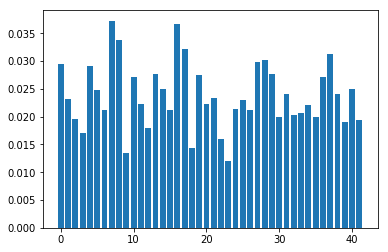

In [221]:
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

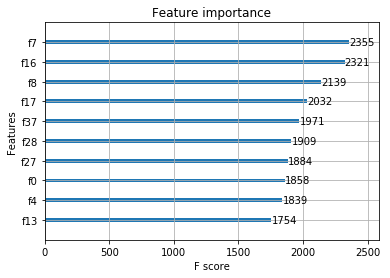

In [240]:
from xgboost import plot_importance
plot_importance(xgb, max_num_features=10)
plt.show()

In [236]:
feature_names = [
    'clean_1_gram_sim',
    'clean_2_gram_sim',
    'clean_3_gram_sim',
    'clean_euc_min_q1',
    'clean_euc_max_q1',
    'clean_euc_avg_q1',
    'clean_cos_min_q1',
    'clean_cos_max_q1',
    'clean_cos_avg_q1',
    'clean_man_min_q1',
    'clean_man_max_q1',
    'clean_man_avg_q1',
    'clean_euc_min_q2',
    'clean_euc_max_q2',
    'clean_euc_avg_q2',
    'clean_cos_min_q2',
    'clean_cos_max_q2',
    'clean_cos_avg_q2',
    'clean_man_min_q2',
    'clean_man_max_q2',
    'clean_man_avg_q2',
    'lemma_1_gram_sim',
    'lemma_2_gram_sim',
    'lemma_3_gram_sim',
    'lemma_euc_min_q1',
    'lemma_euc_max_q1',
    'lemma_euc_avg_q1',
    'lemma_cos_min_q1',
    'lemma_cos_max_q1',
    'lemma_cos_avg_q1',
    'lemma_man_min_q1',
    'lemma_man_max_q1',
    'lemma_man_avg_q1',
    'lemma_euc_min_q2',
    'lemma_euc_max_q2',
    'lemma_euc_avg_q2',
    'lemma_cos_min_q2',
    'lemma_cos_max_q2',
    'lemma_cos_avg_q2',
    'lemma_man_min_q2',
    'lemma_man_max_q2',
    'lemma_man_avg_q1'
    
]
print(len(feature_names))

42


In [253]:
def print_features(l=[7, 16, 8, 17, 37, 28, 27, 0, 4, 13]):
    for n in l:
#         print(n)
        print(feature_names[n])
print_features()

clean_cos_max_q1
clean_cos_max_q2
clean_cos_avg_q1
clean_cos_avg_q2
lemma_cos_max_q2
lemma_cos_max_q1
lemma_cos_min_q1
clean_1_gram_sim
clean_euc_max_q1
clean_euc_max_q2


In [238]:
features[20456, [7, 16, 8, 17, 37]]

array([0.96252071, 1.08482914, 0.72458074, 0.68943047, 1.06595845])

In [239]:
xgb.get_booster().get_fscore()

{'f1': 1467,
 'f21': 1480,
 'f0': 1858,
 'f28': 1909,
 'f7': 2355,
 'f29': 1747,
 'f6': 1340,
 'f8': 2139,
 'f12': 1132,
 'f4': 1839,
 'f16': 2321,
 'f2': 1236,
 'f27': 1884,
 'f17': 2032,
 'f39': 1203,
 'f22': 1014,
 'f13': 1754,
 'f18': 903,
 'f10': 1719,
 'f37': 1971,
 'f19': 1733,
 'f23': 762,
 'f38': 1518,
 'f34': 1402,
 'f5': 1565,
 'f24': 1349,
 'f3': 1081,
 'f25': 1457,
 'f32': 1282,
 'f41': 1225,
 'f15': 1335,
 'f35': 1263,
 'f20': 1412,
 'f26': 1339,
 'f31': 1516,
 'f33': 1309,
 'f9': 848,
 'f36': 1713,
 'f30': 1259,
 'f40': 1576,
 'f11': 1410,
 'f14': 1573}

In [ ]:
#### ask_question('What is the capital of Washington?')
# ask_question('noncontagious definition')
ask_question('where is the stamen located in a flower')

In [188]:
qa_df.loc[:, 'query'].sample()

27505    where is the stamen located in a flower
Name: query, dtype: object

In [167]:
p.argsort()[-3:]

array([21032, 80760, 14203])

In [166]:
questions.iloc[p.argsort()[-3:]]
# questions.iloc[1]

27943     which is the original delmonico's
81699               what state is borths in
21797    what is the meaning of the bowery?
Name: query, dtype: object

In [168]:
q_array = np.array(questions)

In [169]:
q_array[14203]

'what is the meaning of the bowery?'

In [170]:
q_array[80760]

'what state is borths in'

In [72]:
q = ['What is the capital of Washington?']

In [76]:
np.repeat(q, 2, axis=0).shape

(2,)

In [108]:
utils.save(token_text, 'questions_tokenized')


In [104]:
for t in token_text:
    print(type(t))
    break

<class 'numpy.ndarray'>


In [97]:
from nltk import ngrams

In [107]:
for n in ngrams(np.array(token_text[0]), 3, pad_right=True):
    print(n)

(8532415787641010193, 5865838185239622912, 3411606890003347522)
(5865838185239622912, 3411606890003347522, 11901859001352538922)
(3411606890003347522, 11901859001352538922, 14070511896034874754)
(11901859001352538922, 14070511896034874754, None)
(14070511896034874754, None, None)


In [111]:
doc = utils.nlp('What is the capital of Washington?')
q_tokens = doc.to_array([utils.spacy.attrs.LOWER])

In [116]:
np.hstack([np.array(token_text).reshape(-1, 1), np.repeat(q_tokens, len(token_text), axis=0).reshape(1, -1)]).shape

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [117]:
t = np.array(token_text).reshape(-1, 1)

In [118]:
t.shape

(101093, 1)

In [119]:
t

array([[array([ 8532415787641010193,  5865838185239622912,  3411606890003347522,
       11901859001352538922, 14070511896034874754], dtype=uint64)],
       [array([16315412628806490806, 13583488448875926965, 11779693057662023107,
        2619154345045139155, 15597474948775060119, 15099054000809333061,
        1920611397140219205,  3791531372978436496, 13569477888548814854],
      dtype=uint64)],
       [array([16315412628806490806, 13583488448875926965,  7425985699627899538,
       11900862162089982680,  6184037061712818460,  3142894986720291236,
        3791531372978436496, 17339002579355368042,  9095968958430269659,
       10313580197444822952,  9952569212994313472], dtype=uint64)],
       ...,
       [array([16331095434822636218, 12965068231793614765,  3791531372978436496,
        7340758616018961957, 10606469382566443026, 16929211676819693673],
      dtype=uint64)],
       [array([ 3077651023035088716,  6878210874361030284,  3791531372978436496,
       13320680580156776400, 1412212

In [127]:
v = np.repeat(q_tokens, len(token_text))

In [128]:
v.shape

(707651,)

In [124]:
len(token_text)

101093

In [133]:
%%time
ngram_similarity(q_tokens)

CPU times: user 3.62 s, sys: 69 ms, total: 3.69 s
Wall time: 4.64 s


array([[0.33333333, 0.16666667, 0.        ],
       [0.        , 0.        , 0.        ],
       [0.11111111, 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])